In [1]:
%matplotlib notebook

In [15]:
import serial
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque

In [2]:
import serial
import time

COM_PORT = 'COM15'
BAUD_RATE = 19200

try:
    ser = serial.Serial(
        port=COM_PORT,
        baudrate=BAUD_RATE,
        bytesize=serial.EIGHTBITS,
        parity=serial.PARITY_NONE,
        stopbits=serial.STOPBITS_ONE,
        timeout=1
    )

    while True:
        ser.write(b'Q\r\n')
        time.sleep(0.3)
        response = ser.readline().decode(errors='ignore').strip()
        print("Weight:", response or "No response")
        time.sleep(0.5)  # Wait 0.5 seconds between readings

except serial.SerialException as e:
    print(f"Serial error: {e}")

finally:
    if 'ser' in locals() and ser.is_open:
        ser.close()
        print("Serial port closed.")


Weight: ST,+0001.665  g
Weight: ST,+0001.664  g
Weight: ST,+0001.664  g
Weight: ST,+0001.664  g
Serial port closed.


KeyboardInterrupt: 

Connected to COM15 at 19200 baud.
Stopping...
Serial port closed.
Stopped cleanly.


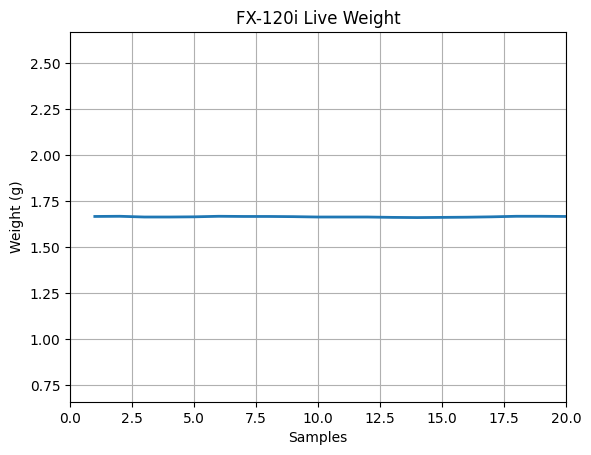

In [1]:
import serial
import time
import matplotlib.pyplot as plt
from collections import deque
import threading

COM_PORT = 'COM15'  # Change if needed
BAUD_RATE = 19200
MAX_POINTS = 100

weights = deque(maxlen=MAX_POINTS)
x_vals = deque(maxlen=MAX_POINTS)

stop_thread = False  # Flag to stop thread safely

# Thread function to read serial data continuously
def serial_reader():
    global stop_thread, weights, x_vals
    sample_num = 0
    try:
        ser = serial.Serial(
            port=COM_PORT,
            baudrate=BAUD_RATE,
            bytesize=serial.EIGHTBITS,
            parity=serial.PARITY_NONE,
            stopbits=serial.STOPBITS_ONE,
            timeout=1
        )
        print(f"Connected to {COM_PORT} at {BAUD_RATE} baud.")
        while not stop_thread:
            ser.write(b'Q\r\n')
            time.sleep(0.3)
            raw = ser.readline().decode(errors='ignore').strip()
            # print("Raw:", raw or "No response")  # Uncomment to debug
            weight = None
            if raw.startswith("ST,") or raw.startswith("US,"):
                try:
                    weight_str = raw.split(',')[1].strip().split()[0]
                    weight = float(weight_str)
                except Exception as e:
                    print("Parse error:", e)

            if weight is not None:
                sample_num += 1
                weights.append(weight)
                x_vals.append(sample_num)
            time.sleep(0.2)

    except serial.SerialException as e:
        print(f"Serial error: {e}")

    finally:
        if 'ser' in locals() and ser.is_open:
            ser.close()
            print("Serial port closed.")

# Start serial reading in a background thread
thread = threading.Thread(target=serial_reader)
thread.start()

# Setup matplotlib plot (interactive)
plt.ion()
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_title("FX-120i Live Weight")
ax.set_xlabel("Samples")
ax.set_ylabel("Weight (g)")
ax.grid(True)

def update_plot():
    while not stop_thread:
        if weights:
            line.set_data(x_vals, weights)
            ax.set_xlim(max(0, x_vals[-1] - MAX_POINTS), x_vals[-1])
            ax.set_ylim(min(weights) - 1, max(weights) + 1)
            fig.canvas.draw_idle()
        time.sleep(0.5)

# Run plot updater in main thread (blocking)
try:
    update_plot()
except KeyboardInterrupt:
    print("Stopping...")

# Signal thread to stop and wait for it
stop_thread = True
thread.join()
print("Stopped cleanly.")
